In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import json
import pathlib
import csv
import random
from preprocessing.preprocessClassifier import load_image, normalize, Augment
from skimage import feature
from skimage import exposure
import cv2
from tqdm import tqdm

In [15]:
BASE_PATH = "./data/croppedEars"
TRAIN_DATA_FOLDER = pathlib.Path(BASE_PATH + "/train")
TEST_DATA_FOLDER = pathlib.Path(BASE_PATH + "/test")
ANOTATIONS_PATH = "./data/annotations/recognition/ids.csv"

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
VAL_RATIO = 0.15

MODEL_NAME = "LBP"

In [16]:
def filenamesAndLabels(path, train=True):
    filenames = ["train/"+x for x in os.listdir(path)] if train else ["test/"+x for x in os.listdir(path)]
    annotationsDict = {}
    
    with open(ANOTATIONS_PATH) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            annotationsDict[row[0]] = int(row[1]) - 1
    
    labels = [annotationsDict[x] for x in filenames]
    filenames = [os.path.join(BASE_PATH, x) for x in filenames]
    
    return filenames, labels

In [17]:
filenames, labels = filenamesAndLabels(TRAIN_DATA_FOLDER)

filenames_train, filenames_val, labels_train, labels_val = train_test_split(filenames, labels, test_size=VAL_RATIO, 
                                random_state=42, shuffle=True, stratify=labels)
filenames_test, labels_test = filenamesAndLabels(TEST_DATA_FOLDER, train=False)


In [18]:
def extractLBP(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    imgEq = exposure.equalize_hist(img)
    lbp = feature.local_binary_pattern(imgEq, P=8, R=2, method="uniform")

    # n_bins = int(lbp.max() + 1)
    # hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    # return hist	

    finalHist = []
    for i in range(0,img.shape[0],8):
        for j in range(0,img.shape[1],8):
            imageBlock = lbp[i:i+8,j:j+8]
            hist,_ = np.histogram(imageBlock, density=True, bins=8)
            finalHist.extend(hist)

    return np.array(finalHist)/np.linalg.norm(finalHist)

In [19]:
X_train = []
for currFile in tqdm(filenames_train):
    featureVec = extractLBP(currFile)
    X_train.append(featureVec)

X_train = np.array(X_train)
y_train = np.array(labels_train)

100%|██████████| 637/637 [01:36<00:00,  6.58it/s]


In [20]:
X_val = []
for currFile in tqdm(filenames_val):
    featureVec = extractLBP(currFile)
    X_val.append(featureVec)

X_val = np.array(X_val)
y_val = np.array(labels_val)

100%|██████████| 113/113 [00:18<00:00,  6.06it/s]


In [21]:
def evalSVM(X_train, X_test, y_train, kernel="rbf",c=1):
    svm = SVC(C=c, kernel=kernel, random_state=42, probability=True)
    model = svm.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return y_pred

In [22]:
def calcRankN(labelsProbs, trueLabel, n=1):
    if n >= len(labelsProbs):
        print("NONE", n)
        return None
    sortedProbs = np.argsort(labelsProbs)[::-1]
    if trueLabel in sortedProbs[:n]:
        return True
    else:
        return False

def displayCMC(ranks, save=False, saveName="CMC"):
    plt.plot(np.arange(1,len(ranks)+1), ranks)
    plt.title('Cumulative Match Curve')
    plt.xlabel('Rank')
    plt.ylabel('Probability of identification')
    plt.savefig(f"./resultsClassifier/{MODEL_NAME}-{saveName}.jpg") if save else plt.show()

In [23]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [24]:
y_predVal = evalSVM(X_train_scaled, X_val_scaled, y_train)

100%|██████████| 113/113 [00:00<00:00, 186.65it/s]


First 5 ranks: [0.01769912 0.01769912 0.01769912 0.01769912 0.02654867]


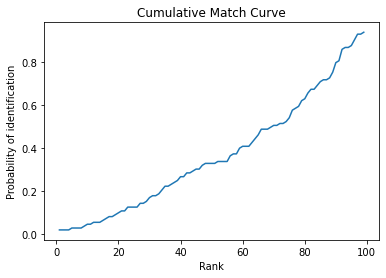

In [25]:
ranks = np.zeros(99)
for i in tqdm(range(y_val.shape[0])):
    label = y_val[i]
    labelsProbs = y_predVal[i,:]
    for i in range(1, 100):
        ranks[i-1] += calcRankN(labelsProbs, label, n=i)

ranks /= len(filenames_val)
print(f"First 5 ranks: {ranks[:5]}")
displayCMC(ranks)

In [26]:
X_test = []
for currFile in tqdm(filenames_test):
    featureVec = extractLBP(currFile)
    X_test.append(featureVec)

X_test = np.array(X_test)
y_test = np.array(labels_test)

100%|██████████| 250/250 [00:52<00:00,  4.80it/s]


In [27]:
X_test_scaled = scaler.transform(X_test)

In [28]:
y_predTest = evalSVM(X_train_scaled, X_test_scaled, y_train)

100%|██████████| 250/250 [00:00<00:00, 356.41it/s]


First 5 ranks: [0.008 0.016 0.024 0.028 0.032]


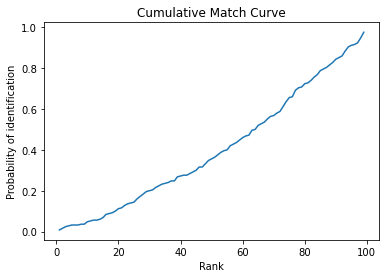

In [30]:
ranks = np.zeros(99)
for i in tqdm(range(y_test.shape[0])):
    label = y_test[i]
    labelsProbs = y_predTest[i,:]
    for i in range(1, 100):
        ranks[i-1] += calcRankN(labelsProbs, label, n=i)

ranks /= len(filenames_test)
print(f"First 5 ranks: {ranks[:5]}")
displayCMC(ranks)

100%|██████████| 250/250 [23:30<00:00,  5.64s/it]


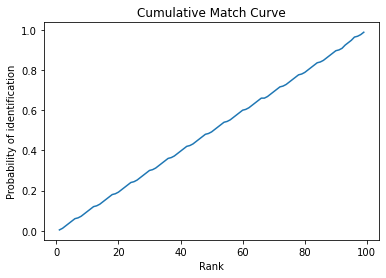

In [44]:
# Using chi-squared for comparisons:
def chi2_distance(A, B):
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)
                        for (a, b) in zip(A, B)]) 
    return chi

ranks = np.zeros(99)
for i in tqdm(range(y_test.shape[0])):
    label = y_test[i]
    currVec = X_test_scaled[i,:]
    distances = np.apply_along_axis(lambda x: chi2_distance(x,currVec), 1, X_train_scaled)
    sortedIx = np.argsort(distances)
    labelsSorted = y_train[sortedIx]
    labelsUnique = np.unique(labelsSorted)
    for i in range(1, 100):
        add = 1 if label in labelsUnique[:i] else 0
        ranks[i-1] += add

ranks /= len(filenames_test)
displayCMC(ranks)

In [53]:

def extractHOG(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    imgEq = exposure.equalize_hist(img)
    hog = feature.hog(imgEq, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2))
    return hog / np.linalg.norm(hog)